# Moment Curvature Analysis

This example demonstrates how to perform a moment curvature analysis using *concreteproperties*. We start by importing the necessary modules.

In [1]:
import numpy as np
from concreteproperties.material import Concrete, SteelBar
import concreteproperties.stress_strain_profile as ssp
from sectionproperties.pre.library.primitive_sections import (
    rectangular_section,
    circular_section,
)
from concreteproperties.pre import add_bar_rectangular_array
from concreteproperties.concrete_section import ConcreteSection
from concreteproperties.results import MomentCurvatureResults

## Assign Materials

Multiple material types will be used in this example to highlight different moment curvature results.

In [2]:
conc_linear = Concrete(
    name="Linear Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinear(
        elastic_modulus=35e3, ultimate_strain=0.0035
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=40,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=3.5,
    colour="lightgrey",
)

conc_linear_no_tension = Concrete(
    name="Linear Concrete (No T)",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinearNoTension(
        elastic_modulus=35e3, ultimate_strain=0.0035
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=40,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=3.5,
    colour="lightgrey",
)


conc_nonlinear = Concrete(
    name="Non-Linear Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.EurocodeNonLinear(
        elastic_modulus=35e3,
        ultimate_strain=0.0035,
        compressive_strength=40,
        compressive_strain=0.0023,
        tensile_strength=3.5,
        tension_softening_stiffness=10e3,
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=40,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=3.5,
    colour="lightgrey",
)

conc_material_list = [
    conc_linear,
    conc_linear_no_tension,
    conc_nonlinear,
]

steel_ep = SteelBar(
    name="Steel - Elastic-Plastic",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelElasticPlastic(
        yield_strength=500,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="grey",
)

steel_hd = SteelBar(
    name="Steel - Hardening",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelHardening(
        yield_strength=500,
        elastic_modulus=200e3,
        fracture_strain=0.05,
        ultimate_strength=600,
    ),
    colour="grey",
)

steel_material_list = [
    steel_ep,
    steel_hd,
]

## Plot Stress-Strain Profiles

Let's use the ``plot_stress_strain()`` method to compare the various service stress-strain profiles:

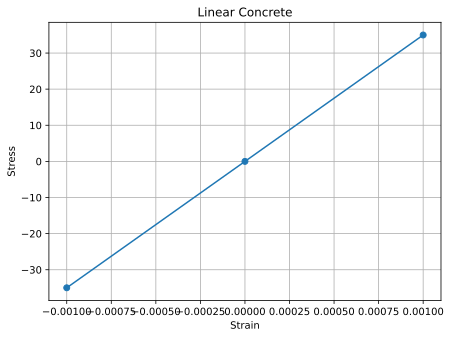

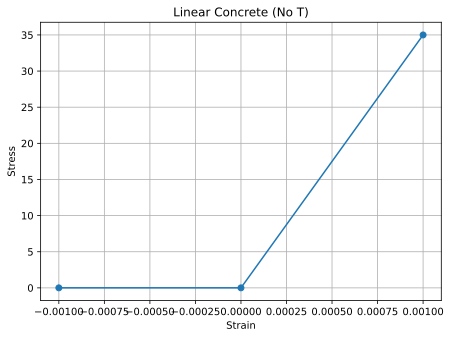

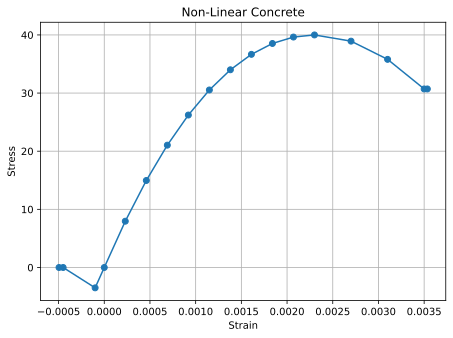

In [3]:
for conc in conc_material_list:
    conc.stress_strain_profile.plot_stress_strain(title=conc.name)

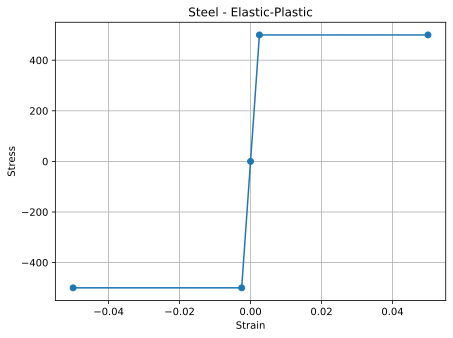

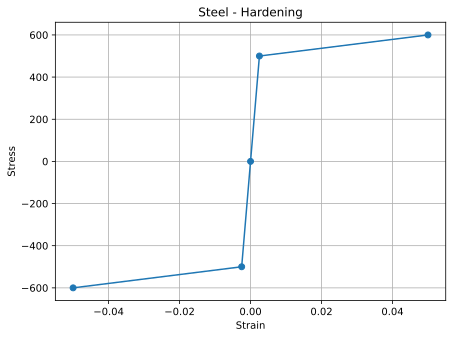

In [4]:
for steel in steel_material_list:
    steel.stress_strain_profile.plot_stress_strain(title=steel.name)

## Create Reinforced Concrete Geometry

The section being analysed in this example is a 350D x 600W concrete column with a 125 mm circular void at its centre. The column is reinforced with 14N24 bars. As we will be using conducting multiple analyses with different material properties, we will assign the concrete material later.

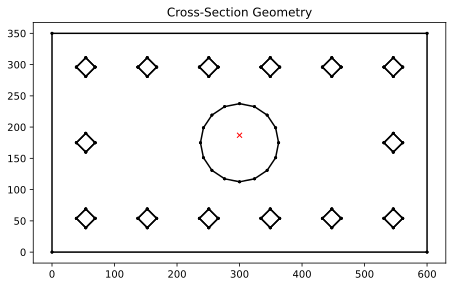

<AxesSubplot: title={'center': 'Cross-Section Geometry'}>

In [5]:
col = rectangular_section(d=350, b=600)
void = circular_section(d=125, n=16).align_center(align_to=col)
col = col - void  # subtract void from column

# add bars to column
geom = add_bar_rectangular_array(
    geometry=col,
    area=450,
    material=steel_ep,
    n_x=6,
    x_s=492 / 5,
    n_y=3,
    y_s=121,
    anchor=(54, 54),
    exterior_only=True,
)

geom.plot_geometry(labels=[], cp=False, legend=False)

## Varying Concrete Properties

In this example we will first study the effect the concrete stress-strain profile has on the moment curvature diagram.

### Moment Curvature Analysis

The below code loops through each concrete material, assigning it to the concrete column geometry and performs a moment curvature analysis.

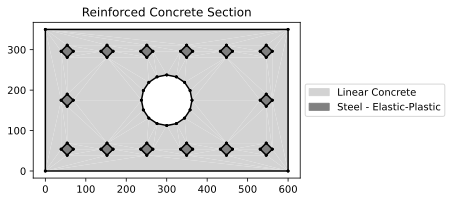

In [6]:
# initialise list to store results and list to store labels
moment_curvature_results = []
labels = []

# loop through each concrete material
for idx, conc in enumerate(conc_material_list):
    # assign concrete material to first geometry in CompoundGeometry object
    geom.geoms[0].material = conc

    # create ConcreteSection object
    conc_sec = ConcreteSection(geom)

    # plot section first time only
    if idx == 0:
        conc_sec.plot_section()

    # perform moment curvature analysis and store results
    # bending about major axis so theta = pi/2
    res = conc_sec.moment_curvature_analysis(theta=np.pi / 2, progress_bar=False)
    moment_curvature_results.append(res)

    # create plot label
    labels.append(conc.name)

### Plotting Results

We can plot the moment curvature results on a single plot by using the ``MomentCurvatureResults.plot_multiple_results()`` method. Note that individual plots can also be generated by using the ``plot_results()`` method.

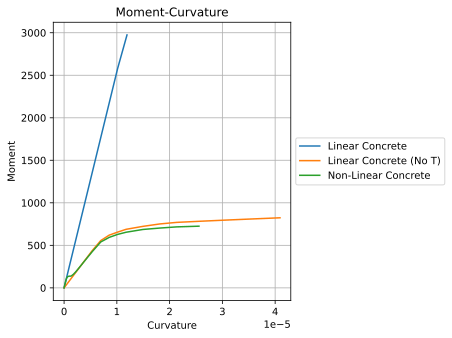

<AxesSubplot: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [7]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=moment_curvature_results, labels=labels, fmt="-"
)

In the above plot, the linear concrete exhibits a much stiffer response when compared to the other two plots. This is because there is no cracking behaviour modelled into the linear concrete stress-strain profile and the concrete fails in compression just after the steel reaches its yield stress. The concrete stresses continue to increase after yielding of the steel until compression failure. This can be confirmed by examining the ``failure_geometry`` attribute.

In [8]:
print(moment_curvature_results[0].failure_geometry.material.name)

Linear Concrete


Let's examine the moment curvature diagrams that do model cracking behaviour further.

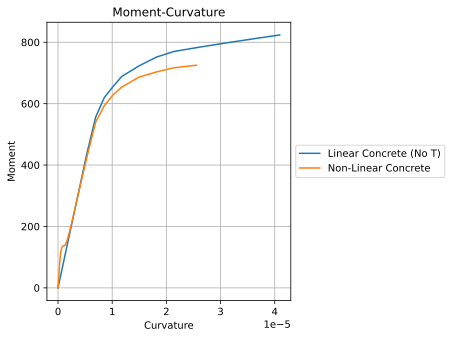

<AxesSubplot: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [9]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=moment_curvature_results[1:], labels=labels[1:], fmt="-"
)

Both plots show similar behaviour with a couple of interesting differences:

1. The non-linear concrete material is able to capture the initial uncracked behaviour and the softening that occurs after cracking. After cracking, the cracked responses are markedly similar.
2. The post yield behaviour for the non-linear material is softer than that of the linear material. This is because the concrete stress for the linear material can continue to increase as the curvature increases, as stresses are extrapolated in the ``ConcreteLinearNoTension`` stress-strain profile and there is no softening of the concrete stress. On the other hand, the non-linear concrete material does model this 'softening' and the resultant moment is thus lower.

### Compare Cracking Moments

Finally, we will compare the cracking moment obtained in an elastic analysis with that from the moment curvature analysis. First we compute the cracking moment using the ``calculate_cracked_properties()`` method.

In [10]:
print(
    f"M_cr = {conc_sec.calculate_cracked_properties(theta=np.pi / 2).m_cr / 1e6:.2f} kN.m"
)

M_cr = 84.76 kN.m


Now let's examine the non-linear concrete response in the initial elastic region.

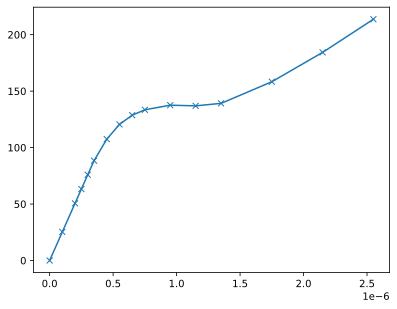

In [11]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots()
kappa = np.array(moment_curvature_results[-1].kappa)
moment = np.array(moment_curvature_results[-1].m_xy) / 1e6
ax.plot(kappa[:16], moment[:16], "x-")
plt.show()

It's clear in the above plot that the softening due to initial cracking occurs between 75 kN.m and 100 kN.m, which aligns well with the elastic result.

## Varying Steel Properties

We will now study the effect the steel stress-strain profile has on the moment curvature diagram.

### Moment Curvature Analysis

The below code loops through each steel material, assigning it to all the steel geometries and performs a moment curvature analysis. By not modifying the concrete material, we are using the last assigned property, i.e. non-linear concrete. Also note that we already have the results for the elastic-plastic steel as this was used in the first analysis.

In [12]:
# initialise list to store results and list to store labels
moment_curvature_results = [moment_curvature_results[-1]]
labels = [steel_material_list[0].name]

# assign hardening steel material to rest of geometries in CompoundGeometry object
steel = steel_material_list[-1]
for g in geom.geoms[1:]:
    g.material = steel

# create ConcreteSection object
conc_sec = ConcreteSection(geom)

# perform moment curvature analysis and store results
# bending about major axis so theta = pi/2
res = conc_sec.moment_curvature_analysis(theta=np.pi / 2, progress_bar=False)
moment_curvature_results.append(res)

# create plot label
labels.append(steel.name)

### Plotting Results

We can plot the moment curvature results on a single plot by using the ``MomentCurvatureResults.plot_multiple_results()`` method.

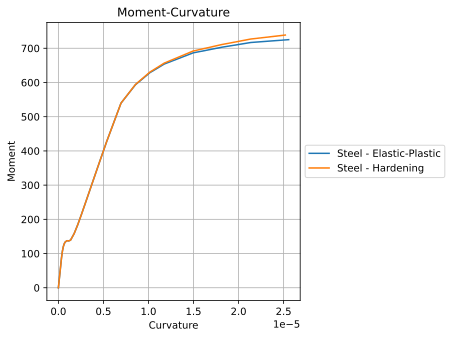

<AxesSubplot: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [13]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=moment_curvature_results, labels=labels, fmt="-"
)

The above plot shows that the moment curvature response is identical up until the point of steel yielding, as expected. Beyond the yield point, the section with the hardening steel becomes slightly stiffer than the section with the perfectly plastic steel. This is because the stresses in the reinforcing steel continue to harden beyond the yield point, resulting in a slightly larger moment.

## Finetuning Analysis Parameters
There are a number of analysis parameters that can be finetuned to control the moment curvature analysis. These will be explored in this example.

We start by creating a simple geometry with relatively simple material properties (linear concrete with no tension & elastic-plastic steel).

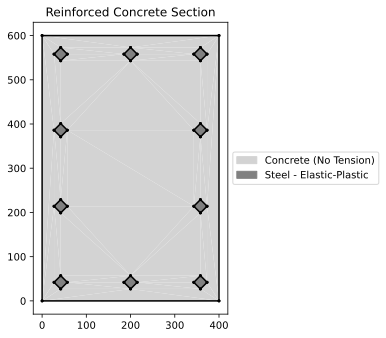

<AxesSubplot: title={'center': 'Reinforced Concrete Section'}>

In [14]:
concrete = Concrete(
    name="Concrete (No Tension)",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinearNoTension(
        elastic_modulus=35e3,
        ultimate_strain=0.003,
        compressive_strength=40,
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=40,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=3.5,
    colour="lightgrey",
)

geom = rectangular_section(d=600, b=400, material=concrete)

geom = add_bar_rectangular_array(
    geometry=geom,
    area=450,
    material=steel_ep,
    n_x=3,
    x_s=158,
    n_y=4,
    y_s=172,
    anchor=(42, 42),
    exterior_only=True,
)

conc_sec = ConcreteSection(geom)
conc_sec.plot_section()

### Default Analysis Parameters

In [15]:
res1 = conc_sec.moment_curvature_analysis(progress_bar=False)

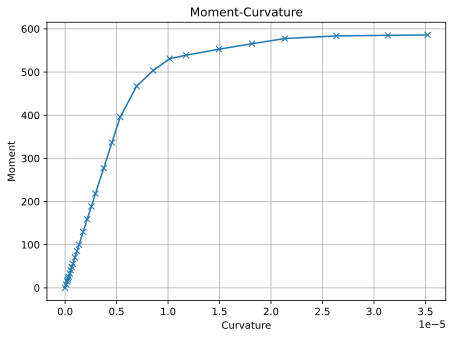

Number of calculations = 30
Failure curvature = 3.5212e-05


In [16]:
res1.plot_results(fmt="x-")
print(f"Number of calculations = {len(res1.kappa)}")
print(f"Failure curvature = {res1.kappa[-1]:.4e}")

In the above plot we waste a lot of time calculating the initial linear behaviour and can not be super confident that we have captured the yielding behaviour well. However, we don't spend too much time in the yielded plateau region as the curvature increment is adaptively increased.

### Initial Curvature Increment
In this example we change the initial curvature increment from ``1e-7`` (default) to ``5e-6``.

In [17]:
res2 = conc_sec.moment_curvature_analysis(kappa_inc=5e-6, progress_bar=False)

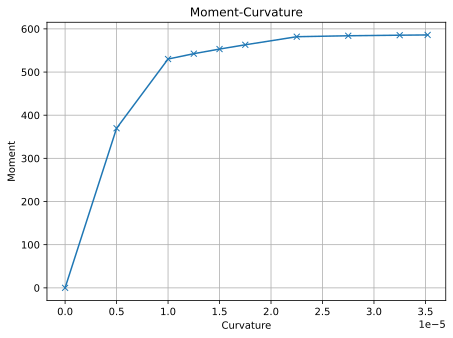

Number of calculations = 10
Failure curvature = 3.5212e-05


In [18]:
res2.plot_results(fmt="x-")
print(f"Number of calculations = {len(res2.kappa)}")
print(f"Failure curvature = {res2.kappa[-1]:.4e}")

We now save a lot of time in the initial linear region compared to the previous plot however the yielding behaviour is not super well described.

### Further Refinement
In this example we change the following parameters:

- ``kappa_inc=3e-7`` - a balance between the previous two examples
- ``kappa_mult=1.25`` - smoother changes in curvature increment (default = ``2``)
- ``delta_m_min=0.1`` - only increase the curvature increment if the change in moment is less than 10% (default = 15%)
- ``kappa_inc_max=2e-5`` - allow larger curvature increments, can be useful in the plateau region (default = ``5e-6``)

In [19]:
res3 = conc_sec.moment_curvature_analysis(
    kappa_inc=3e-7,
    kappa_mult=1.25,
    delta_m_min=0.1,
    kappa_inc_max=2e-5,
    progress_bar=False,
)

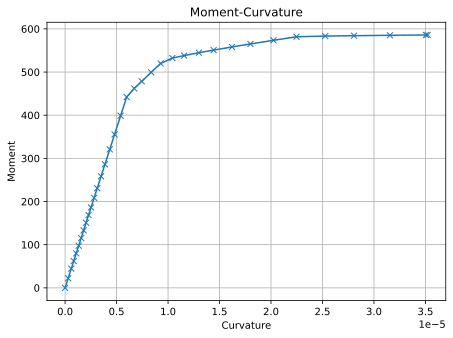

Number of calculations = 36
Failure curvature = 3.5212e-05


In [20]:
res3.plot_results(fmt="x-")
print(f"Number of calculations = {len(res3.kappa)}")
print(f"Failure curvature = {res3.kappa[-1]:.4e}")

### Summary
Note that all failure curvatures are the same, regardless of the analysis parameters the failure point is always included in the results.

Let's compare the most granular result (``res3``) with the result with the fastest computation time (``res2``).

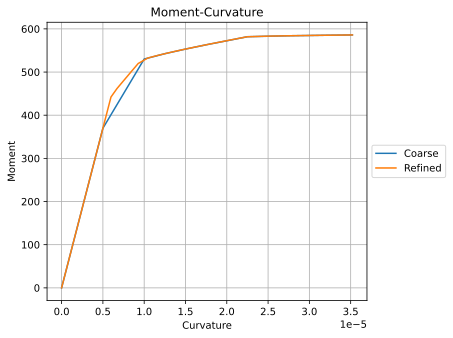

<AxesSubplot: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [21]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=[res2, res3],
    labels=["Coarse", "Refined"],
    fmt="-",
)

Note that the behaviour is largely similar, however the refined parameters do a better job of capturing the yielding behaviour.